# `neural_network_race_winner_bet_random_walk.ipynb`

### Author: Anthony Hein

#### Last updated: 12/7/2021

# Overview:

Use the neural network which has been trained to predict pairwise winners of a race to now resolve an entire race and visualize its "goodness" as the random walk of the balance of a bettor using the neural network.

---

## Setup

In [1]:
import git
import os
import re
from typing import List
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [2]:
BASE_DIR = git.Repo(os.getcwd(), search_parent_directories=True).working_dir
BASE_DIR

'/Users/anthonyhein/Desktop/SML310/project'

---

## Load `horses_selected_trimmed_clean.csv`

In [3]:
horses_clean = pd.read_csv(f"{BASE_DIR}/data/streamline/horses_selected_trimmed_clean.csv", low_memory=False)
horses_clean.head()

,rid,horseName,age,saddle,decimalPrice,isFav,trainerName,jockeyName,position,positionL,...,RPR,TR,OR,father,mother,gfather,weight,res_win,res_place,res_show
0,302858,Kings Return,6.0,4.0,0.600000,1,W P Mullins,D J Casey,1,0,...,102.0,NaN,NaN,King's Ride,Browne's Return,Deep Run,73,1,1,0
1,302858,Majestic Red I,6.0,5.0,0.047619,0,John Hackett,Conor O'Dwyer,2,8,...,94.0,NaN,NaN,Long Pond,Courtlough Lady,Giolla Mear,73,0,1,0
2,302858,Clearly Canadian,6.0,2.0,0.166667,0,D T Hughes,G Cotter,3,1.5,...,92.0,NaN,NaN,Nordico,Over The Seas,North Summit,71,0,0,0
3,302858,Bernestic Wonder,8.0,1.0,0.058824,0,E McNamara,J Old Jones,4,dist,...,NaN,NaN,NaN,Roselier,Miss Reindeer,Reindeer,73,0,0,0
4,302858,Beauty's Pride,5.0,6.0,0.038462,0,J J Lennon,T Martin,5,dist,...,NaN,NaN,NaN,Noalto,Elena's Beauty,Tarqogan,66,0,0,0


In [4]:
horses_clean = horses_clean[['rid', 'horseName', 'decimalPrice', 'position', 'res_win', 'res_place', 'res_show']]

---

## Load `X_train_preprocess_without_race.csv`

In [5]:
X_train = pd.read_csv(f"{BASE_DIR}/data/analysis/X_train_preprocess_without_race.csv", low_memory=False)
X_train.head()

,horse1_age,horse1_saddle,horse1_decimalPrice,horse1_isFav,horse1_outHandicap,horse1_RPR,horse1_weight,horse1_jockey_d_last_race,horse1_jockey_d_first_race,horse1_jockey_prev_1_position,...,horse2_jockey_prev_3_position_rain,horse2_jockey_prev_1_finishing_time_ratio_rain,horse2_jockey_prev_2_finishing_time_ratio_rain,horse2_jockey_prev_3_finishing_time_ratio_rain,horse2_jockey_prev_1_position_rhum,horse2_jockey_prev_2_position_rhum,horse2_jockey_prev_3_position_rhum,horse2_jockey_prev_1_finishing_time_ratio_rhum,horse2_jockey_prev_2_finishing_time_ratio_rhum,horse2_jockey_prev_3_finishing_time_ratio_rhum
0,0.200000,0.230769,0.196970,0.0,0.0,0.73125,0.692308,0.007631,0.236544,0.100,...,0.050,0.805104,0.780139,0.783438,0.100,0.025,0.025,0.805104,0.799642,0.780139
1,0.400000,0.038462,0.072222,0.0,0.0,0.73125,0.743590,0.005050,0.236544,0.100,...,0.100,0.801416,0.781238,0.794160,0.075,0.050,0.075,0.801416,0.800487,0.785703
2,0.133333,0.423077,0.098485,0.0,0.0,0.65000,0.705128,0.000740,0.237283,0.025,...,0.100,0.799909,0.780139,0.786816,0.025,0.100,0.025,0.799642,0.806486,0.780139
3,0.133333,0.423077,0.098485,0.0,0.0,0.65000,0.705128,0.000740,0.237283,0.025,...,0.075,0.800176,0.781623,0.781870,0.050,0.075,0.050,0.801163,0.801416,0.780963
4,0.133333,0.192308,0.090278,0.0,0.0,0.66250,0.730769,0.000740,0.234655,0.050,...,0.100,0.799642,0.783601,0.785468,0.125,0.100,0.025,0.803191,0.805104,0.780139


In [6]:
X_train.shape

(800666, 144)

---

## Load `X_dev_preprocess_without_race.csv`

In [7]:
X_dev = pd.read_csv(f"{BASE_DIR}/data/analysis/X_dev_preprocess_without_race.csv", low_memory=False)
X_dev.head()

,horse1_age,horse1_saddle,horse1_decimalPrice,horse1_isFav,horse1_outHandicap,horse1_RPR,horse1_weight,horse1_jockey_d_last_race,horse1_jockey_d_first_race,horse1_jockey_prev_1_position,...,horse2_jockey_prev_3_position_rain,horse2_jockey_prev_1_finishing_time_ratio_rain,horse2_jockey_prev_2_finishing_time_ratio_rain,horse2_jockey_prev_3_finishing_time_ratio_rain,horse2_jockey_prev_1_position_rhum,horse2_jockey_prev_2_position_rhum,horse2_jockey_prev_3_position_rhum,horse2_jockey_prev_1_finishing_time_ratio_rhum,horse2_jockey_prev_2_finishing_time_ratio_rhum,horse2_jockey_prev_3_finishing_time_ratio_rhum
0,0.285714,0.105263,0.200000,0.0,0.0,0.608392,0.769231,0.001516,0.629407,0.250,...,0.200,0.828972,0.837641,0.843255,0.075,0.050,0.275,0.834583,0.828972,0.853796
1,0.285714,0.210526,0.157143,0.0,0.0,0.258741,0.769231,0.000445,0.286087,0.075,...,0.075,0.826039,0.826039,0.842799,0.025,0.025,0.075,0.826039,0.826039,0.842799
2,0.285714,0.210526,0.157143,0.0,0.0,0.258741,0.769231,0.000445,0.286087,0.075,...,0.125,0.826413,0.841758,0.844367,0.125,0.050,0.275,0.843955,0.826413,0.841758
3,0.285714,0.210526,0.157143,0.0,0.0,0.258741,0.769231,0.000445,0.286087,0.075,...,0.050,0.832401,0.832114,0.828366,0.100,0.075,0.050,0.832401,0.837064,0.828519
4,0.285714,0.210526,0.157143,0.0,0.0,0.258741,0.769231,0.000445,0.286087,0.075,...,0.175,0.857255,0.835266,0.834946,0.150,0.025,0.200,0.857255,0.826039,0.837392


In [8]:
X_dev.shape

(228766, 144)

---

## Load `X_train_preprocess_without_race.csv`

In [9]:
X_test = pd.read_csv(f"{BASE_DIR}/data/analysis/X_test_preprocess_without_race.csv", low_memory=False)
X_test.head()

,horse1_age,horse1_saddle,horse1_decimalPrice,horse1_isFav,horse1_outHandicap,horse1_RPR,horse1_weight,horse1_jockey_d_last_race,horse1_jockey_d_first_race,horse1_jockey_prev_1_position,...,horse2_jockey_prev_3_position_rain,horse2_jockey_prev_1_finishing_time_ratio_rain,horse2_jockey_prev_2_finishing_time_ratio_rain,horse2_jockey_prev_3_finishing_time_ratio_rain,horse2_jockey_prev_1_position_rhum,horse2_jockey_prev_2_position_rhum,horse2_jockey_prev_3_position_rhum,horse2_jockey_prev_1_finishing_time_ratio_rhum,horse2_jockey_prev_2_finishing_time_ratio_rhum,horse2_jockey_prev_3_finishing_time_ratio_rhum
0,0.230769,0.333333,0.03268,0.0,0.0,0.344828,0.74359,0.001053,0.49501,0.225,...,0.200,0.865544,0.847264,0.853154,0.025,0.200,0.300,0.840533,0.850856,0.864844
1,0.230769,0.333333,0.03268,0.0,0.0,0.344828,0.74359,0.001053,0.49501,0.225,...,0.150,0.864781,0.840533,0.855519,0.025,0.025,0.025,0.840533,0.840533,0.840533
2,0.230769,0.333333,0.03268,0.0,0.0,0.344828,0.74359,0.001053,0.49501,0.225,...,0.075,0.838534,0.843337,0.846422,0.200,0.100,0.125,0.853412,0.842583,0.847859
3,0.230769,0.333333,0.03268,0.0,0.0,0.344828,0.74359,0.001053,0.49501,0.225,...,0.250,0.851685,0.849673,0.854624,0.150,0.250,0.200,0.849673,0.854624,0.858051
4,0.230769,0.333333,0.03268,0.0,0.0,0.344828,0.74359,0.001053,0.49501,0.225,...,0.250,0.847892,0.842776,0.862423,0.175,0.075,0.275,0.853634,0.844529,0.862845


In [10]:
X_test.shape

(114392, 144)

---

## Load `races_selected_trimmed_clean.csv`

In [11]:
races_clean = pd.read_csv(f"{BASE_DIR}/data/streamline/races_selected_trimmed_clean.csv", low_memory=False)
races_clean.head()

,rid,course,title,winningTime,metric,ncond,class,runners,margin,1st_place_rank_in_odds,...,station name,station lat,station lng,dist to station,station reading date,temp,msl,rain,rhum,station reading timedelta
0,302858,Thurles,Liffey Maiden Hurdle (Div 1),277.2,3821.0,1,0,6,1.219263,1,...,BIRR,53.0525,-7.5325,45.288813,1/9/97 12:00,1.6,1012.4,0.0,87,15.0
1,291347,Punchestown,Ericsson G.S.M. Grand National Trial Handicap ...,447.2,5229.0,5,0,9,1.218049,4,...,CASEMENT,53.1820,-6.2620,24.477602,2/16/97 15:00,8.0,992.5,0.4,87,20.0
2,75447,Listowel,Ballybunion E.B.F. Beginners S'chase,318.4,3620.0,5,0,8,1.277320,3,...,SHANNON AIRPORT,52.4125,-8.5505,63.534139,3/1/97 14:00,12.0,1003.5,0.0,73,0.0
3,358038,Punchestown,Quinns Of Baltinglass Chase (La Touche) (Cross...,533.9,6637.0,1,0,10,1.286595,1,...,CASEMENT,53.1820,-6.2620,24.477602,4/24/97 14:00,12.6,1011.9,0.0,72,20.0
4,89211,Tipperary,Topaz Sprint Stakes (Listed),59.9,1005.0,4,0,5,1.217043,4,...,SHANNON AIRPORT,52.4125,-8.5505,25.222137,5/8/97 17:00,11.1,994.2,0.0,59,30.0


---

## Load Identifying Info

In [12]:
X_train_identifiers = pd.read_csv(f"{BASE_DIR}/data/analysis/X_train_identifiers.csv", low_memory=False)
X_train_identifiers.head()

,rid,horse1_horseName,horse2_horseName
0,341451,Dance Design,Idris
1,341451,Idris,Dance Design
2,50025,Azra,Johan Cruyff
3,50025,Azra,Beautiful Fire
4,50025,Johan Cruyff,Azra


In [13]:
X_dev_identifiers = pd.read_csv(f"{BASE_DIR}/data/analysis/X_dev_identifiers.csv", low_memory=False)
X_dev_identifiers.head()

,rid,horse1_horseName,horse2_horseName
0,159686,Gussy Goose,Ibergman
1,159686,Mothers Finest,Emergent
2,159686,Mothers Finest,Gussy Goose
3,159686,Mothers Finest,Just Joan
4,159686,Mothers Finest,Rayisa


In [14]:
X_test_identifiers = pd.read_csv(f"{BASE_DIR}/data/analysis/X_test_identifiers.csv", low_memory=False)
X_test_identifiers.head()

,rid,horse1_horseName,horse2_horseName
0,136782,Sestriere,Associate Rock
1,136782,Sestriere,Fridtjof Nansen
2,136782,Sestriere,Pillar
3,136782,Sestriere,Captain Power
4,136782,Sestriere,Frow


---

## Find Races w/ All Runners Present

The correctness of this function is demonstrated elsewhere.

In [15]:
def runners_to_num_pairs(runners: int) -> int:
    """
    Calculates the number of 2-tuple permutations
    for a given amount runners.
    """
    return runners * (runners - 1)

In [16]:
def find_races_all_runners_present(df: pd.core.frame.DataFrame) -> List[int]:
    df = df.groupby("rid").count()
    df = df.merge(races_clean[['rid', 'runners']], on='rid')
    df['permutations'] = df['runners'].map(runners_to_num_pairs)
    return list(df[df['permutations'] == df['horse1_horseName']]['rid'])

In [17]:
X_train_all_runners_present = find_races_all_runners_present(X_train_identifiers)
len(X_train_all_runners_present)

3212

In [18]:
X_dev_all_runners_present = find_races_all_runners_present(X_dev_identifiers)
len(X_dev_all_runners_present)

1012

In [19]:
X_test_all_runners_present = find_races_all_runners_present(X_test_identifiers)
len(X_test_all_runners_present)

360

---

## Load Neural Network

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Set the device to use
# CUDA refers to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Fixing Random Seed for Reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [21]:
X_train_plus_identifiers = X_train.join(X_train_identifiers)
X_dev_plus_identifiers = X_dev.join(X_dev_identifiers)
X_test_plus_identifiers = X_test.join(X_test_identifiers)

In [22]:
X_train_plus_identifiers = X_train_plus_identifiers[X_train_plus_identifiers['rid'].isin(X_train_all_runners_present)]
X_dev_plus_identifiers = X_dev_plus_identifiers[X_dev_plus_identifiers['rid'].isin(X_dev_all_runners_present)]
X_test_plus_identifiers = X_test_plus_identifiers[X_test_plus_identifiers['rid'].isin(X_test_all_runners_present)]

In [23]:
X_train.shape

(800666, 144)

In [24]:
X_train_plus_identifiers.shape

(239188, 147)

In [25]:
X_train_plus_identifiers.head()

,horse1_age,horse1_saddle,horse1_decimalPrice,horse1_isFav,horse1_outHandicap,horse1_RPR,horse1_weight,horse1_jockey_d_last_race,horse1_jockey_d_first_race,horse1_jockey_prev_1_position,...,horse2_jockey_prev_3_finishing_time_ratio_rain,horse2_jockey_prev_1_position_rhum,horse2_jockey_prev_2_position_rhum,horse2_jockey_prev_3_position_rhum,horse2_jockey_prev_1_finishing_time_ratio_rhum,horse2_jockey_prev_2_finishing_time_ratio_rhum,horse2_jockey_prev_3_finishing_time_ratio_rhum,rid,horse1_horseName,horse2_horseName
46,0.2,0.115385,0.098485,0.0,0.0,0.29375,0.692308,0.000008,0.261505,0.10,...,0.780139,0.025,0.025,0.025,0.799642,0.799642,0.780139,337765,Plaza De Toros,Mingling Glances
47,0.2,0.115385,0.098485,0.0,0.0,0.29375,0.692308,0.000008,0.261505,0.10,...,0.788387,1.000,0.075,0.050,0.868119,0.802540,0.784381,337765,Plaza De Toros,Johan Cruyff
48,0.2,0.076923,0.541667,1.0,0.0,0.64375,0.692308,0.000008,0.235628,0.05,...,0.788387,1.000,0.075,0.050,0.868119,0.802540,0.784381,337765,Olympic Majesty,Johan Cruyff
49,0.2,0.038462,0.120370,0.0,0.0,0.68750,0.692308,0.000340,0.264441,0.05,...,0.785794,0.050,0.075,0.075,0.803869,0.814859,0.781684,337765,Johan Cruyff,Olympic Majesty
50,0.2,0.038462,0.120370,0.0,0.0,0.68750,0.692308,0.000340,0.264441,0.05,...,0.780139,0.025,0.025,0.025,0.799642,0.799642,0.780139,337765,Johan Cruyff,Mingling Glances


In [26]:
drop_cols = ['rid', 'horse1_horseName', 'horse2_horseName']

X_train_only_all_runners_present = X_train_plus_identifiers.drop(columns=drop_cols)
X_dev_only_all_runners_present = X_dev_plus_identifiers.drop(columns=drop_cols)
X_test_only_all_runners_present = X_test_plus_identifiers.drop(columns=drop_cols)

In [27]:
X_train_tensor = torch.from_numpy(X_train_only_all_runners_present.to_numpy()).float().to(device)
X_dev_tensor = torch.from_numpy(X_dev_only_all_runners_present.to_numpy()).float().to(device)
X_test_tensor = torch.from_numpy(X_test_only_all_runners_present.to_numpy()).float().to(device)

In [28]:
class Net(nn.Module):
    def __init__(self, input_size, num_layers, layers_size):
        super(Net, self).__init__()
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, layers_size)])
        self.hidden_layers.extend([nn.Linear(layers_size, layers_size) for i in range(1, num_layers-1)])
        self.output = nn.Linear(layers_size, 1)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        z = x
        for layer in self.hidden_layers:
            z = self.activation(layer(z))
        return self.output(z)

In [29]:
net = Net(X_train_tensor.shape[1], 1, 150)
net.load_state_dict(torch.load(f"{BASE_DIR}/data/analysis/neural_network/net_all_features_150_nodes.bin"))
net.eval()

Net(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=144, out_features=150, bias=True)
  )
  (output): Linear(in_features=150, out_features=1, bias=True)
  (activation): ReLU()
)

## Compute Predictions

The predicted winner will have won the most pairwise matchups

In [30]:
from collections import defaultdict

In [31]:
with torch.no_grad():
    train_preds = torch.sigmoid(net.forward(X_train_tensor))
    dev_preds = torch.sigmoid(net.forward(X_dev_tensor))
    test_preds = torch.sigmoid(net.forward(X_test_tensor))

In [32]:
X_train_plus_identifiers['predictions'] = train_preds
X_dev_plus_identifiers['predictions'] = dev_preds
X_test_plus_identifiers['predictions'] = test_preds

In [33]:
X_train_plus_identifiers[['rid', 'horse1_horseName', 'horse2_horseName', 'predictions']].head()

,rid,horse1_horseName,horse2_horseName,predictions
46,337765,Plaza De Toros,Mingling Glances,2.578393e-07
47,337765,Plaza De Toros,Johan Cruyff,2.090218e-08
48,337765,Olympic Majesty,Johan Cruyff,1.747337e-01
49,337765,Johan Cruyff,Olympic Majesty,9.360530e-01
50,337765,Johan Cruyff,Mingling Glances,9.993711e-01


In [34]:
X_train_predictions = {}

for rid in X_train_all_runners_present:

    race_d = defaultdict(lambda: 0)
    
    df = X_train_plus_identifiers[X_train_plus_identifiers['rid'] == rid]
    
    for _, row in df.iterrows():
        race_d[row['horse1_horseName']] += row['predictions']
        race_d[row['horse2_horseName']] += 1 - row['predictions']
        
    X_train_predictions[rid] = max(race_d, key=race_d.get)

In [35]:
X_dev_predictions = {}

for rid in X_dev_all_runners_present:

    race_d = defaultdict(lambda: 0)
    
    df = X_dev_plus_identifiers[X_dev_plus_identifiers['rid'] == rid]
    
    for _, row in df.iterrows():
        race_d[row['horse1_horseName']] += row['predictions']
        race_d[row['horse2_horseName']] += 1 - row['predictions']
        
    X_dev_predictions[rid] = max(race_d, key=race_d.get)

In [36]:
X_test_predictions = {}

for rid in X_test_all_runners_present:

    race_d = defaultdict(lambda: 0)
    
    df = X_test_plus_identifiers[X_test_plus_identifiers['rid'] == rid]
    
    for _, row in df.iterrows():
        race_d[row['horse1_horseName']] += row['predictions']
        race_d[row['horse2_horseName']] += 1 - row['predictions']
        
    X_test_predictions[rid] = max(race_d, key=race_d.get)

---

## Preprare Walk

We need to make a helper dictionary that maps `rid` to the winner.

In [37]:
rid_to_winner = {}

for rid in X_train_all_runners_present:
    
    df = horses_clean[horses_clean['rid'] == rid]
    rid_to_winner[rid] = df[df['position'] == 1].iloc[0]['horseName']
    
for rid in X_dev_all_runners_present:
    
    df = horses_clean[horses_clean['rid'] == rid]
    rid_to_winner[rid] = df[df['position'] == 1].iloc[0]['horseName']
    
for rid in X_test_all_runners_present:
    
    df = horses_clean[horses_clean['rid'] == rid]
    rid_to_winner[rid] = df[df['position'] == 1].iloc[0]['horseName']

In [38]:
races_train = races_clean[races_clean['rid'].isin(X_train_all_runners_present)]
races_train.shape

(3212, 34)

In [39]:
races_train['datetime']

23       1997-06-06 17:30:00
2745     2009-03-20 17:30:00
2751     2009-03-22 13:15:00
2754     2009-03-22 14:15:00
2755     2009-03-22 14:45:00
                ...         
20128    1999-10-16 15:50:00
20129    1999-10-16 15:20:00
20130    1999-10-16 13:45:00
20158    1999-10-25 13:45:00
20163    1999-10-29 14:30:00
Name: datetime, Length: 3212, dtype: object

In [40]:
races_train['datetime'] = pd.to_datetime(races_train['datetime'])

/var/folders/s0/crtdyrfd7gq75c2mmz_rn9340000gn/T/ipykernel_43797/870046472.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  races_train['datetime'] = pd.to_datetime(races_train['datetime'])


In [41]:
races_train['datetime']

23      1997-06-06 17:30:00
2745    2009-03-20 17:30:00
2751    2009-03-22 13:15:00
2754    2009-03-22 14:15:00
2755    2009-03-22 14:45:00
                ...        
20128   1999-10-16 15:50:00
20129   1999-10-16 15:20:00
20130   1999-10-16 13:45:00
20158   1999-10-25 13:45:00
20163   1999-10-29 14:30:00
Name: datetime, Length: 3212, dtype: datetime64[ns]

In [42]:
races_dev = races_clean[races_clean['rid'].isin(X_dev_all_runners_present)]
races_dev['datetime'] = pd.to_datetime(races_dev['datetime'])
races_dev.shape

/var/folders/s0/crtdyrfd7gq75c2mmz_rn9340000gn/T/ipykernel_43797/1810544999.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  races_dev['datetime'] = pd.to_datetime(races_dev['datetime'])


(1012, 34)

In [43]:
races_train = races_train.sort_values(by='datetime')
races_train[['rid', 'title', 'datetime']].head().head()

,rid,title,datetime
23,337765,Gallinule Stakes (Group 2),1997-06-06 17:30:00
19216,397240,Challenge Stakes (Listed),1998-07-18 14:40:00
19255,370591,Arthur's Race,1998-07-31 19:40:00
19263,59197,Desert King Stakes (Listed),1998-08-02 14:00:00
19261,22972,Bluebird Platinum Stakes (Listed),1998-08-02 15:30:00


In [44]:
races_dev = races_dev.sort_values(by='datetime')
races_dev[['rid', 'title', 'datetime']].head()

,rid,title,datetime
18393,159686,Arthur Guinness European Breeders Fund Corrib ...,2016-07-28 14:30:00
18395,20184,Guinness 17:59 European Breeders Fund Median A...,2016-07-29 16:45:00
18396,2751,Guinness European Breeders Fund Maiden,2016-07-29 19:30:00
18400,142304,"""Ladbrokes"" European Breeders Fund Maiden (Plu...",2016-07-30 14:50:00
18403,135972,Kenny Galway European Breeders Fund Fillies Ma...,2016-07-31 16:30:00


---

## Visualize Walk

In [45]:
horses_clean[horses_clean['rid'] == 159686]

,rid,horseName,decimalPrice,position,res_win,res_place,res_show
184566,159686,Planchart,0.230769,1,1,1,0
184567,159686,Rayisa,0.285714,2,0,1,0
184568,159686,Ibergman,0.100000,3,0,0,0
184569,159686,Just Joan,0.066667,4,0,0,0
184570,159686,Gussy Goose,0.181818,5,0,0,0
184571,159686,Emergent,0.133333,6,0,0,0
184572,159686,Mothers Finest,0.142857,7,0,0,0


The following is the payout of a $2 wager.

In [46]:
1 / horses_clean[
    (horses_clean['rid'] == 159686) & (horses_clean['horseName'] == rid_to_winner[159686])
].iloc[0]['decimalPrice']

4.333333333333335

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3212/3212 [00:30<00:00, 106.10it/s]


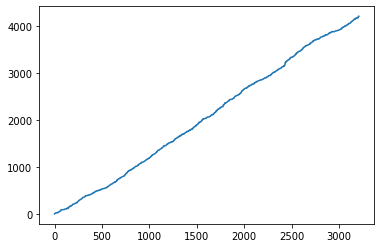

In [47]:
balance = 0
xs = np.array(races_train['datetime'])
ys = []

for rid in tqdm(races_train['rid']):
    balance -= 1
    
    if X_train_predictions[rid] == rid_to_winner[rid]:
        df = horses_clean[horses_clean['rid'] == rid]
        balance += (1 / horses_clean[
            (horses_clean['rid'] == rid) & (horses_clean['horseName'] == rid_to_winner[rid])
        ].iloc[0]['decimalPrice']) / 2
        
    ys.append(balance)
    
plt.plot(np.arange(len(ys)), ys)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1012/1012 [00:09<00:00, 108.11it/s]


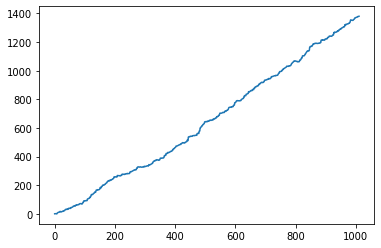

In [48]:
balance = 0
xs = np.array(races_dev['datetime'])
ys = []

for rid in tqdm(races_dev['rid']):
    balance -= 1
    
    if X_dev_predictions[rid] == rid_to_winner[rid]:
        df = horses_clean[horses_clean['rid'] == rid]
        balance += (1 / horses_clean[
            (horses_clean['rid'] == rid) & (horses_clean['horseName'] == rid_to_winner[rid])
        ].iloc[0]['decimalPrice']) / 2
        
    ys.append(balance)
    
plt.plot(np.arange(len(ys)), ys)

---

## Make Comparison to Odds

In [49]:
def get_predicted_winner(df: pd.core.frame.DataFrame) -> str:
    """
    Returns the horse with the best odds for race `df`,
    tiebreaking in lexicographic order.
    """
    df = df.sort_values(['decimalPrice', 'horseName'], ascending=[False, True])
    return df.iloc[0]['horseName']

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3212/3212 [00:46<00:00, 69.25it/s]


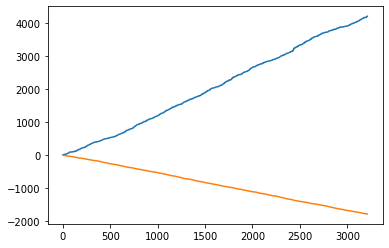

In [50]:
balance_nn = 0
ys_nn_train = []

balance_odds = 0
ys_odds_train = []

for rid in tqdm(races_train['rid']):
    balance_nn -= 1
    balance_odds -= 1
    
    payout = (1 / horses_clean[
        (horses_clean['rid'] == rid) & (horses_clean['horseName'] == rid_to_winner[rid])
    ].iloc[0]['decimalPrice']) / 2
    
    if X_train_predictions[rid] == rid_to_winner[rid]:
        balance_nn += payout
    
    if get_predicted_winner(horses_clean[horses_clean['rid'] == rid]) == rid_to_winner[rid]:
        balance_odds += payout
        
    ys_nn_train.append(balance_nn)
    ys_odds_train.append(balance_odds)
    
plt.plot(np.arange(len(ys_nn_train)), ys_nn_train)
plt.plot(np.arange(len(ys_odds_train)), ys_odds_train)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1012/1012 [00:16<00:00, 61.45it/s]


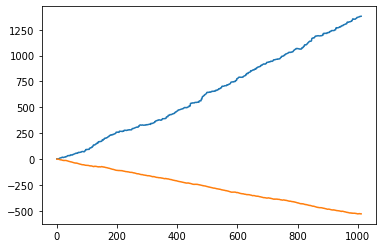

In [51]:
balance_nn = 0
ys_nn_dev = []

balance_odds = 0
ys_odds_dev = []

for rid in tqdm(races_dev['rid']):
    balance_nn -= 1
    balance_odds -= 1
    
    payout = (1 / horses_clean[
        (horses_clean['rid'] == rid) & (horses_clean['horseName'] == rid_to_winner[rid])
    ].iloc[0]['decimalPrice']) / 2
    
    if X_dev_predictions[rid] == rid_to_winner[rid]:
        balance_nn += payout
    
    if get_predicted_winner(horses_clean[horses_clean['rid'] == rid]) == rid_to_winner[rid]:
        balance_odds += payout
        
    ys_nn_dev.append(balance_nn)
    ys_odds_dev.append(balance_odds)
    
plt.plot(np.arange(len(ys_nn_dev)), ys_nn_dev)
plt.plot(np.arange(len(ys_odds_dev)), ys_odds_dev)

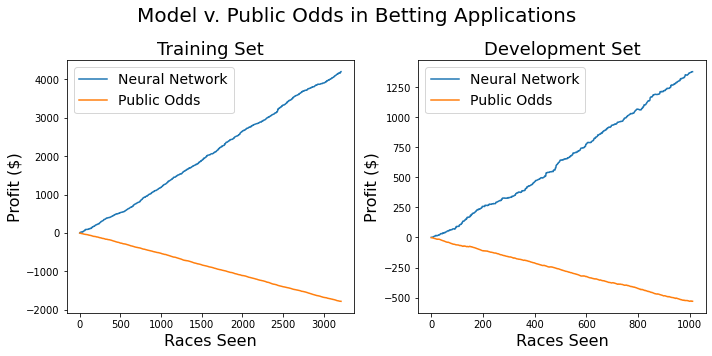

In [52]:
fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(1, 2)

fig.suptitle("Model v. Public Odds in Betting Applications", fontsize=20)

ax1 = fig.add_subplot(gs[0:1, 0:1])

ax1.set_title("Training Set", fontsize=18)
ax1.plot(np.arange(len(ys_nn_train)), ys_nn_train, label='Neural Network')
ax1.plot(np.arange(len(ys_odds_train)), ys_odds_train, label='Public Odds')
ax1.set_xlabel("Races Seen", fontsize=16)
ax1.set_ylabel("Profit ($)", fontsize=16)
ax1.legend(fontsize=14)

ax2 = fig.add_subplot(gs[0:1, 1:2])

ax2.set_title("Development Set", fontsize=18)
ax2.plot(np.arange(len(ys_nn_dev)), ys_nn_dev, label='Neural Network')
ax2.plot(np.arange(len(ys_odds_dev)), ys_odds_dev, label='Public Odds')
ax2.set_xlabel("Races Seen", fontsize=16)
ax2.set_ylabel("Profit ($)", fontsize=16)
ax2.legend(fontsize=14)

plt.tight_layout()

fig.savefig(f"{BASE_DIR}/figures/model_v_odds_in_betting.png")

plt.show()

---